# Model Training and Evaluation

This notebook includes:
- Model training with multiple algorithms
- Learning curves
- ROC-AUC curves
- Confusion matrix
- Feature importance
- Model comparison

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, f1_score, accuracy_score
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from data_preprocessing import ChurnDataPreprocessor

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load and Preprocess Data

In [2]:
# Load and preprocess
preprocessor = ChurnDataPreprocessor()
df = preprocessor.load_data('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
X, y = preprocessor.prepare_data(df, fit=True)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nChurn distribution:\n{y.value_counts()}")

Loaded 7043 records
Data cleaned. Shape: (7043, 20)


Features engineered. New shape: (7043, 25)
Categorical features encoded
Numerical features scaled
Features shape: (7043, 24)
Target shape: (7043,)

Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

Training set: (5634, 24)
Test set: (1409, 24)
Train churn rate: 26.54%
Test churn rate: 26.54%


## 2. Handle Class Imbalance with SMOTE

In [4]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}")
print(f"Balanced training set: {X_train_balanced.shape}")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Original training set: (5634, 24)
Balanced training set: (8278, 24)

Class distribution after SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


## 3. Train Multiple Models

In [5]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

# Train and evaluate
results = {}
predictions = {}
probabilities = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    predictions[name] = y_pred
    probabilities[name] = y_pred_proba
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': auc(*roc_curve(y_test, y_pred_proba)[:2])
    }
    
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  F1 Score: {results[name]['f1_score']:.4f}")
    print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")


Training Logistic Regression...
  Accuracy: 0.7488
  F1 Score: 0.6101
  ROC-AUC: 0.8314

Training Random Forest...


  Accuracy: 0.7637
  F1 Score: 0.5874
  ROC-AUC: 0.8219

Training Gradient Boosting...


  Accuracy: 0.7573
  F1 Score: 0.6166
  ROC-AUC: 0.8338

Training XGBoost...
  Accuracy: 0.7757
  F1 Score: 0.6050
  ROC-AUC: 0.8125


## 4. Model Comparison Visualization

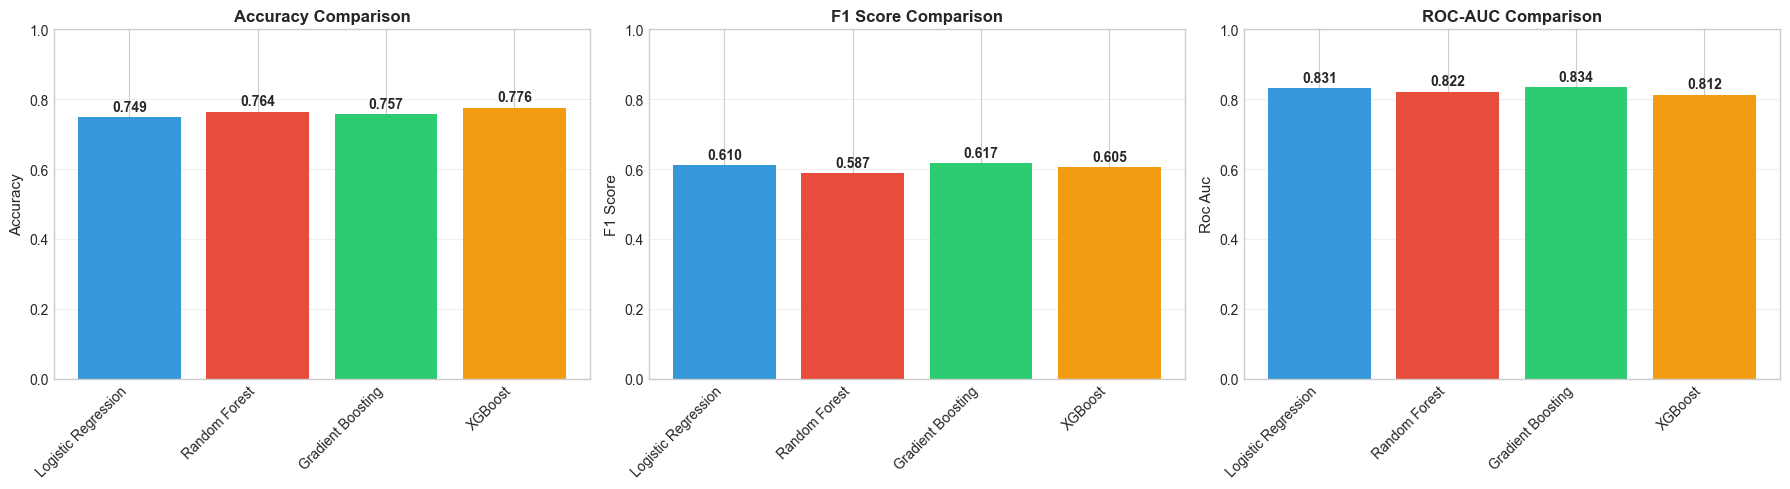


Model Performance Summary:
                     accuracy  f1_score  roc_auc
Logistic Regression    0.7488    0.6101   0.8314
Random Forest          0.7637    0.5874   0.8219
Gradient Boosting      0.7573    0.6166   0.8338
XGBoost                0.7757    0.6050   0.8125


In [6]:
# Create comparison dataframe
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['accuracy', 'f1_score', 'roc_auc']
titles = ['Accuracy Comparison', 'F1 Score Comparison', 'ROC-AUC Comparison']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    bars = axes[idx].bar(results_df.index, results_df[metric], color=colors)
    axes[idx].set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[idx].set_xticklabels(results_df.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../notebooks/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel Performance Summary:")
print(results_df.round(4))

## 5. ROC Curves for All Models

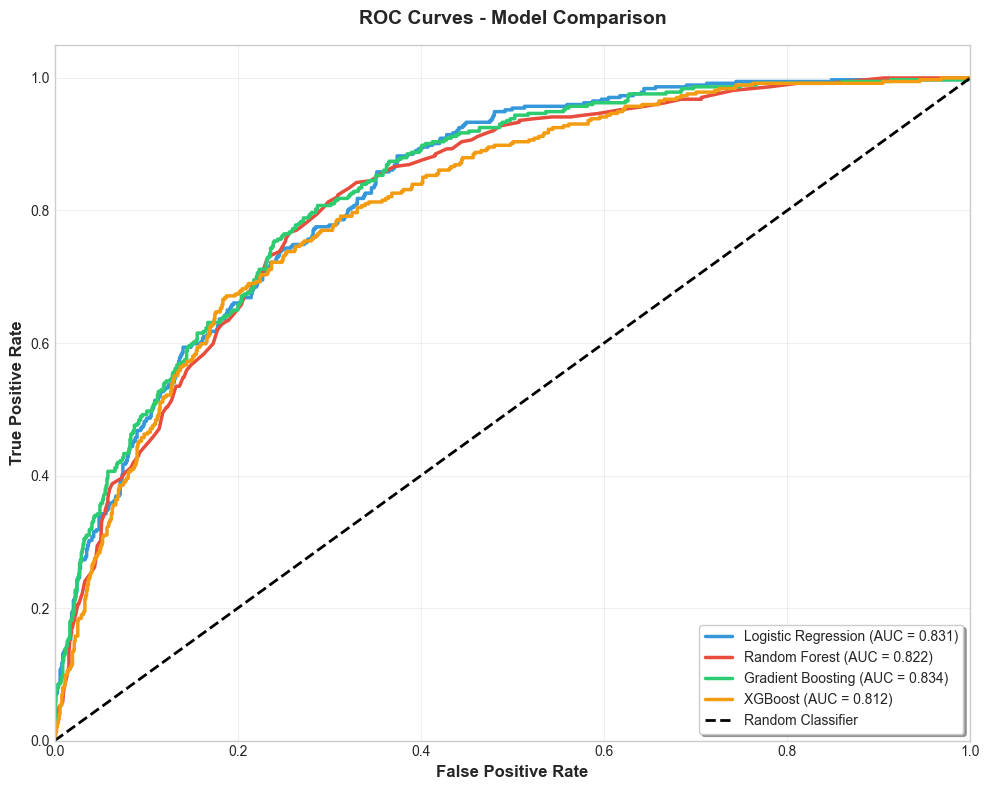

In [7]:
plt.figure(figsize=(10, 8))

colors_map = {
    'Logistic Regression': '#3498db',
    'Random Forest': '#e74c3c',
    'Gradient Boosting': '#2ecc71',
    'XGBoost': '#f39c12'
}

for name, y_pred_proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2.5, label=f'{name} (AUC = {roc_auc:.3f})',
             color=colors_map[name])

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../notebooks/figures/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Learning Curves for Best Model (XGBoost)

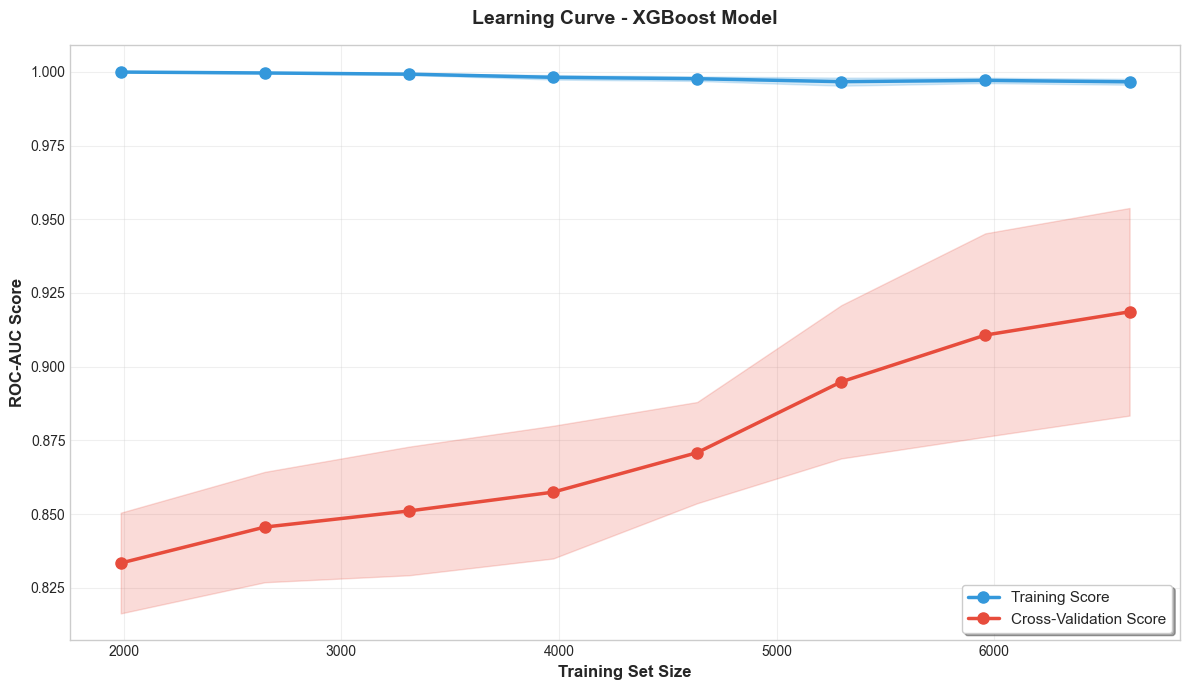

Final Training Score: 0.9966 (+/- 0.0010)
Final CV Score: 0.9186 (+/- 0.0352)


In [8]:
# Load the best model
best_model = joblib.load('../models/churn_model.joblib')

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_balanced, y_train_balanced,
    cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, 'o-', color='#3498db', linewidth=2.5, 
         markersize=8, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='#3498db')

plt.plot(train_sizes, val_mean, 'o-', color='#e74c3c', linewidth=2.5, 
         markersize=8, label='Cross-Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='#e74c3c')

plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('Learning Curve - XGBoost Model', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../notebooks/figures/learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final Training Score: {train_mean[-1]:.4f} (+/- {train_std[-1]:.4f})")
print(f"Final CV Score: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")

## 7. Confusion Matrix - Best Model

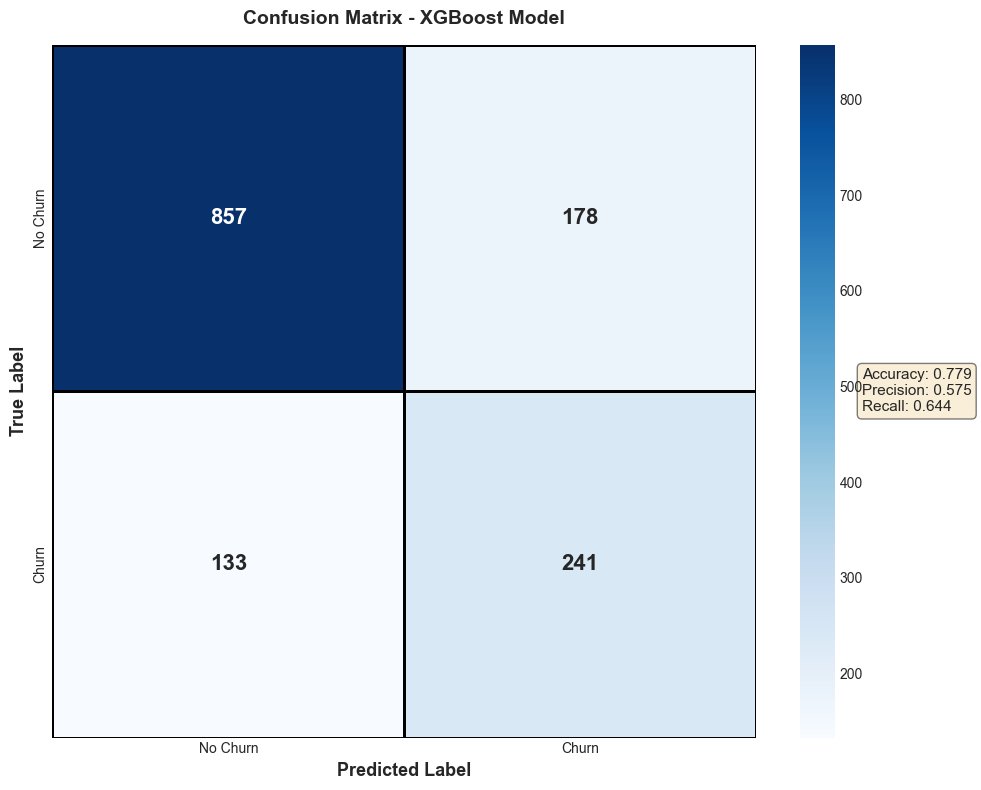


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.87      0.83      0.85      1035
       Churn       0.58      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



In [9]:
# Confusion matrix for best model
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'],
            annot_kws={'size': 16, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')

plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Confusion Matrix - XGBoost Model', fontsize=14, fontweight='bold', pad=15)

# Add accuracy info
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

info_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}'
plt.text(1.15, 0.5, info_text, transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../notebooks/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

## 8. Precision-Recall Curve

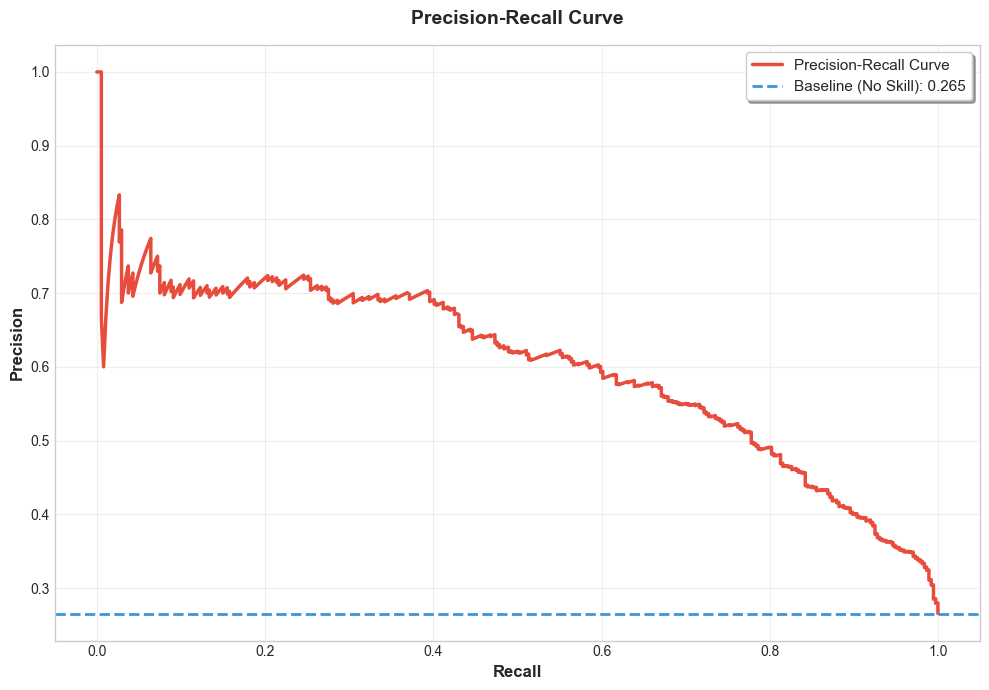

In [10]:
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, linewidth=2.5, color='#e74c3c', label='Precision-Recall Curve')
plt.axhline(y=y_test.mean(), color='#3498db', linestyle='--', linewidth=2, 
            label=f'Baseline (No Skill): {y_test.mean():.3f}')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../notebooks/figures/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Feature Importance

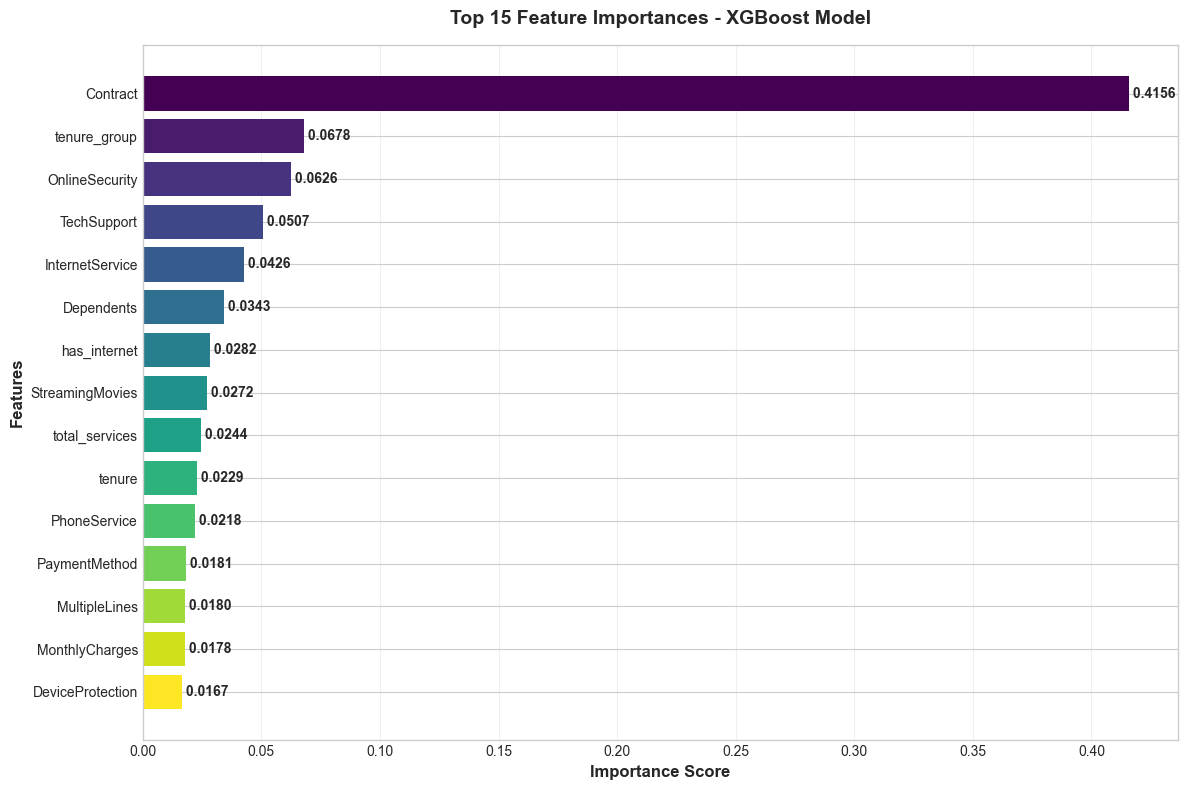


Top 10 Most Important Features:
        feature  importance
       Contract    0.415637
   tenure_group    0.067794
 OnlineSecurity    0.062618
    TechSupport    0.050739
InternetService    0.042636
     Dependents    0.034313
   has_internet    0.028206
StreamingMovies    0.027239
 total_services    0.024420
         tenure    0.022949


In [11]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
top_features = feature_importance.head(15)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importances - XGBoost Model', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_features['importance'])):
    plt.text(value, i, f' {value:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 10. Model Performance Summary

In [12]:
print("=" * 70)
print("MODEL TRAINING SUMMARY")
print("=" * 70)

print("\n1. Dataset:")
print(f"   - Total samples: {len(df)}")
print(f"   - Training samples (after SMOTE): {len(X_train_balanced)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Features: {X.shape[1]}")

print("\n2. Best Model: XGBoost (Hyperparameter Tuned)")
print(f"   - ROC-AUC: {results['XGBoost']['roc_auc']:.4f}")
print(f"   - Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"   - F1 Score: {results['XGBoost']['f1_score']:.4f}")

print("\n3. Top 3 Predictive Features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n4. Model Artifacts Saved:")
print("   - models/churn_model.joblib")
print("   - models/preprocessor.joblib")
print("   - models/metrics.json")
print("   - models/feature_importance.json")

print("\n" + "=" * 70)

MODEL TRAINING SUMMARY

1. Dataset:
   - Total samples: 7043
   - Training samples (after SMOTE): 8278
   - Test samples: 1409
   - Features: 24

2. Best Model: XGBoost (Hyperparameter Tuned)
   - ROC-AUC: 0.8125
   - Accuracy: 0.7757
   - F1 Score: 0.6050

3. Top 3 Predictive Features:
   - Contract: 0.4156
   - tenure_group: 0.0678
   - OnlineSecurity: 0.0626

4. Model Artifacts Saved:
   - models/churn_model.joblib
   - models/preprocessor.joblib
   - models/metrics.json
   - models/feature_importance.json

